# ModelV1
First version of the model. It doesn't have any g-buffer or temporal frames as input or implicit neural representation for high-frequency reconstruction.

In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

c:\Dev\MinorProject\WDSS\jupyter_notebooks
c:\Dev\MinorProject\WDSS


In [2]:
import torch
import torch.nn as nn
from commons import initialize
from config import Settings, device

In [3]:
from network.dataset import WDSSdataset
from network.modules.feature_extractors import LRFrameFeatureExtractor, HRGBufferFeatureExtractor
from network.modules.reconstruction_modules import FeatureFusion

In [5]:
class WDSSV1(nn.Module):
    def __init__(self):
        super(WDSSV1, self).__init__()

        self.upscale_factor = 2
        self.lr_frame_feature_extractor = LRFrameFeatureExtractor(12, 32, [32, 32])
        self.feature_fusion = FeatureFusion(32, 12, [64, 48])

    def forward(self, lr_frame: torch.Tensor) -> torch.Tensor:
        # Perform space to depth operation with scale factor 2
        lr_frame_unsuffled = torch.nn.functional.pixel_unshuffle(lr_frame, 2)

        lr_frame_features = self.lr_frame_feature_extractor(lr_frame_unsuffled)
        # # Bilinear upsample the features
        lr_frame_features_upsampled = nn.functional.interpolate(lr_frame_features, scale_factor=self.upscale_factor, mode='bilinear')
        # # Feature fusion
        hr_frame = self.feature_fusion(lr_frame_features_upsampled)

        # # Perform depth to space operation with scale factor 2
        hr_frame = torch.nn.functional.pixel_shuffle(hr_frame, 2)

        return hr_frame 

In [6]:
from torch.utils.data import DataLoader, Dataset
from utils.image_utils import ImageUtils

class WDSSV1Dataset(Dataset):
    def __init__(self, dataset_dir: str):
        self.dataset_dir = dataset_dir
        self.high_res_frames_dir = 'High_Res'
        self.low_res_frames_dir = 'Low_Res'
        self.high_res_frames = self._get_files(self.high_res_frames_dir)
        self.low_res_frames = self._get_files(self.low_res_frames_dir)

    def _get_files(self, sub_dir: str):
        folder = os.path.join(self.dataset_dir, sub_dir)
        files = [os.path.join(folder, file) for file in os.listdir(folder)]
        # Remove the first one
        files.pop(0)
        return files
    
    def __len__(self):
        return len(self.high_res_frames)
    
    def __getitem__(self, idx):
        high_res_frame = ImageUtils.load_exr_image_opencv(self.high_res_frames[idx])
        low_res_frame = ImageUtils.load_exr_image_opencv(self.low_res_frames[idx])

        # Permute dimensions to CxHxW from HxWxC
        high_res_frame = high_res_frame.transpose(2, 0, 1)
        low_res_frame = low_res_frame.transpose(2, 0, 1)

        return {
            'hr_frame': torch.tensor(high_res_frame).to(device),
            'lr_frame': torch.tensor(low_res_frame).to(device)
        }


In [7]:
dataset = WDSSV1Dataset('D:\\Dev\\MinorProjDataset\\V1\\Asian_Village_Demo\\DATA')
print(dataset[0]['lr_frame'].shape)

torch.Size([3, 360, 640])


In [8]:
model = WDSSV1().to(device)

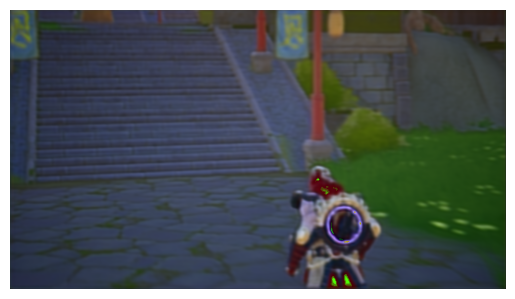

In [11]:
lr_frame = dataset[55]['lr_frame']
hr_frame = dataset[55]['hr_frame']

res = model(lr_frame.unsqueeze(0))
ImageUtils.display_image(res)

In [14]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.00002)
criterion = nn.MSELoss()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

epochs = 10

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        lr_frames = batch['lr_frame']
        hr_frames = batch['hr_frame']

        preds = model(lr_frames)
        loss = criterion(preds, hr_frames)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch: {epoch}, Loss: {epoch_loss}')


Epoch: 0, Loss: 0.003025451849680394
Epoch: 1, Loss: 0.0030046449101064354
Epoch: 2, Loss: 0.00296987738693133
Epoch: 3, Loss: 0.0029601447749882936
Epoch: 4, Loss: 0.002936098608188331
Epoch: 5, Loss: 0.0029554740176536143
Epoch: 6, Loss: 0.0029405511741060764
Epoch: 7, Loss: 0.002948698791442439
Epoch: 8, Loss: 0.0029464535473380238
Epoch: 9, Loss: 0.0029484326078090817


In [15]:
# Ensure the directory exists
os.makedirs('model', exist_ok=True)

# Save the model
torch.save(model.state_dict(), 'model/wdss_v1.pth')

In [10]:
# Load the model
model.load_state_dict(torch.load('model/wdss_v1.pth'))

C:\Users\Prateek\AppData\Local\Temp\ipykernel_16064\847260007.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model/wdss_v1.pth'))


<All keys matched successfully>

Error with bilinear upsampled: 0.00035284130717627704
Error with predicted: 0.0004166578291915357


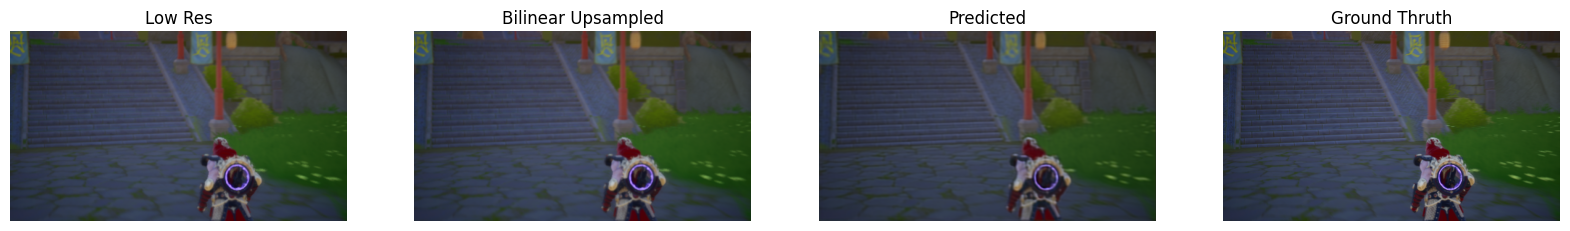

In [21]:
# Display the result
lr_frame_unsqueezed = lr_frame.unsqueeze(0)
model.eval()
with torch.no_grad():
    res = model(lr_frame.unsqueeze(0))
upsampled = nn.functional.interpolate(lr_frame.unsqueeze(0), scale_factor=2, mode='bilinear')

# Compare the error with bilinear upsampled image
print(f'Error with bilinear upsampled: {torch.nn.functional.mse_loss(hr_frame, upsampled.squeeze(0))}')
print(f'Error with predicted: {torch.nn.functional.mse_loss(hr_frame, res.squeeze(0))}')

ImageUtils.display_images([lr_frame.cpu(), upsampled.cpu(), res.cpu(), hr_frame.cpu()], ['Low Res', 'Bilinear Upsampled', 'Predicted', 'Ground Thruth'])

In [39]:
%%time

with torch.no_grad():
    res = model(lr_frame_unsqueezed)

CPU times: total: 0 ns
Wall time: 2 ms
